<div style="background:#222222; color:#ffffff; padding:20px">
    <h2 align="center">Deep Learning Fundamentals</h2>
    <h2 align="center" style="color:#01ff84">Multiclass Clasification: MNIST</h2>
<div>

## Imports

In [44]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd

from torchvision import datasets, transforms

## Auxliary plotting function

In [45]:
# https://discuss.pytorch.org/t/view-classify-in-module-helper/30279/6

def view_classify(img, ps):

    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

# Load MNIST Dataset
First up, we need to get our dataset. This is provided through the `torchvision` package. The code below will download the MNIST dataset, then create training and test datasets for us. Don't worry too much about the details here, you'll learn more about this later.

In [46]:
class FashionDataset(Dataset):

    def __init__(self, data, transform=None):

        self.fashion_MNIST = list(data.values)
        self.transform = transform

        label = []
        image = []

        for i in self.fashion_MNIST:
            label.append(i[0])
            image.append(i[1:])

        self.labels = np.asarray(label)
        self.images = np.asarray(image).reshape(-1, 28, 28, 1).astype('float32')

    def __getitem__(self, index):

        label = self.labels[index]
        image = self.images[index]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):

        return len(self.images)



train_csv = pd.read_csv(r'C:\Users\Pablo\Desktop\STRIVE AI\Deep-learning-challenge\data\fashion-mnist_train.csv')
test_csv = pd.read_csv(r'C:\Users\Pablo\Desktop\STRIVE AI\Deep-learning-challenge\data\fashion-mnist_test.csv')

trainset = FashionDataset(train_csv, transform=transforms.Compose([transforms.ToTensor()]))
testset = FashionDataset(test_csv, transform=transforms.Compose([transforms.ToTensor()]))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=True)

In [47]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

We have the training data loaded into `trainloader` and we make that an iterator with `iter(trainloader)`. We'd use this to loop through the dataset for training, but here I'm just grabbing the first batch so we can check out the data. We can see below that `images` is just a tensor with size (64, 1, 28, 28). So, 64 images per batch, 1 color channel, and 28x28 images.

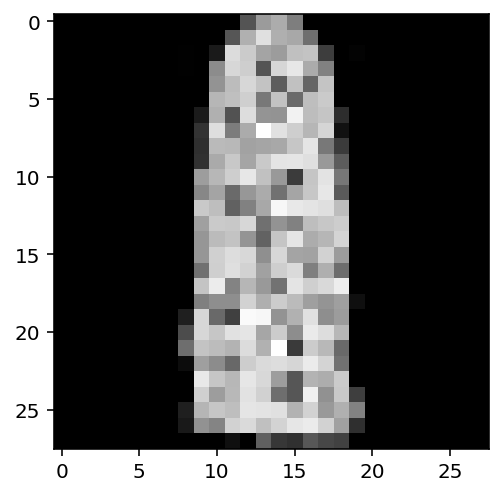

In [54]:
plt.imshow(images[6].numpy().squeeze(), cmap='Greys_r');

In [33]:
class Network(nn.Module):
    
    # Defining the layers, 128, 64, 10 units each
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        
    # Forward pass through the network, returns the output logits
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        return x

model = Network()
model

Network(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

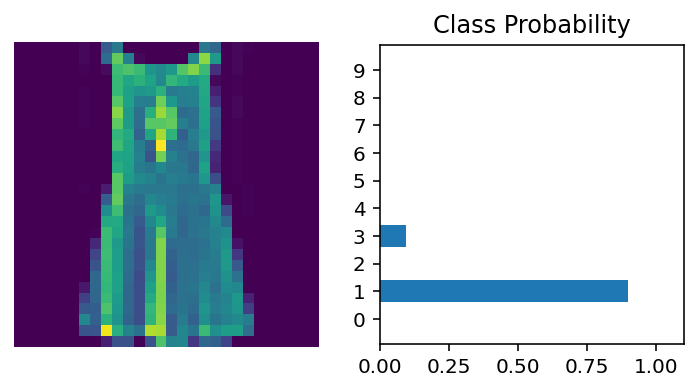

In [34]:
# Grab some data 
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Resize images into a 1D vector, new shape is (batch size, color channels, image pixels) 
images.resize_(64, 1, 784)
# or images.resize_(images.shape[0], 1, 784) to not automatically get batch size

# Forward pass through the network
img_idx = 0
ps = model.forward(images[img_idx,:])

img = images[img_idx]
view_classify(img.view(1, 28, 28), ps)

## Training the network!

The first thing we need to do for training is define our loss function. In PyTorch, you'll usually see this as `criterion`. Here we're using softmax output, so we want to use `criterion = nn.CrossEntropyLoss()` as our loss. Later when training, you use `loss = criterion(output, targets)` to calculate the actual loss.

We also need to define the optimizer we're using, SGD or Adam, or something along those lines. Here I'll just use SGD with `torch.optim.SGD`, passing in the network parameters and the learning rate.

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [42]:
## TODO: Your training loop here
epochs = 100
optimizer = optim.SGD(model.parameters(), lr=0.003)


for e in range(epochs):
    for i, (images, labels) in enumerate(iter(trainloader)):
        # Flatten MNIST images into a 784 long vector
        images.resize_(images.size()[0], 784)
        model.train()
        optimizer.zero_grad()
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(iter(testloader)):
            images.resize_(images.size()[0], 784)
            test_output = model.forward(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            correct += (pred_y == labels).float().sum()
            total += len(labels)
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
    print(f'epoch {e+1} done: accuracy of {(correct/total).float()}')
    model.train()

epoch 1 done: accuracy of 0.8216000199317932
epoch 2 done: accuracy of 0.8206999897956848
epoch 3 done: accuracy of 0.8216000199317932
epoch 4 done: accuracy of 0.8206999897956848
epoch 5 done: accuracy of 0.8197000026702881
epoch 6 done: accuracy of 0.8217999935150146
epoch 7 done: accuracy of 0.819599986076355
epoch 8 done: accuracy of 0.8216000199317932
epoch 9 done: accuracy of 0.8208000063896179
epoch 10 done: accuracy of 0.820900022983551
epoch 11 done: accuracy of 0.8206999897956848
epoch 12 done: accuracy of 0.823199987411499
epoch 13 done: accuracy of 0.820900022983551
epoch 14 done: accuracy of 0.8220999836921692
epoch 15 done: accuracy of 0.819100022315979
epoch 16 done: accuracy of 0.819599986076355
epoch 17 done: accuracy of 0.8205000162124634
epoch 18 done: accuracy of 0.8213000297546387
epoch 19 done: accuracy of 0.8217999935150146
epoch 20 done: accuracy of 0.8188999891281128
epoch 21 done: accuracy of 0.8205999732017517
epoch 22 done: accuracy of 0.8206999897956848
epo

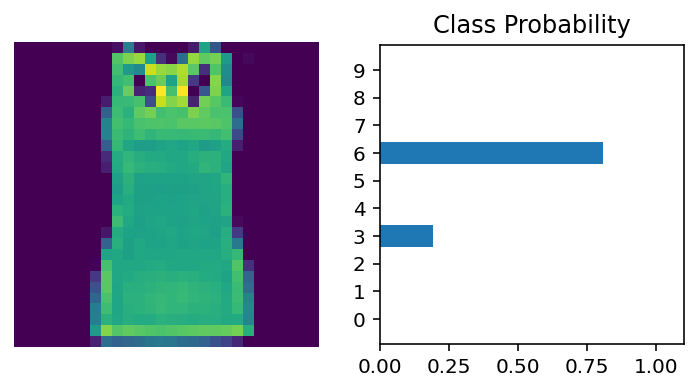

In [40]:
# Run this cell with your model to make sure it works and predicts well for the validation data
images, labels = next(iter(testloader))
images.resize_(images.shape[0], 1, 784)
ps = model.forward(images[0,:])
view_classify(images[0].view(1, 28, 28), ps)

<div style="background:#222222; color:#ffffff; padding:20px">
  <h3 style="color:#01ff84; margin-top:4px">Exercise 3:</h3>
  <p>Write the code for adding <strong style="color:#01ff84">Early Stopping with patience = 2</strong> to the training loop from scratch.</p>
  <p><strong style="color:#01ff84">Hint:</strong> Monitor the Validation loss every epoch, and if in 2 epochs, the validation loss does not improve, stop the training loop with <code>break</code>.</p>
<div>

In [27]:
from torch.optim.lr_scheduler import StepLR
## TODO: Your training loop here
epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
scheduler = StepLR(optimizer, step_size=20, gamma=0.1)
loss_anterior = 0
for e in range(epochs):
    for i, (images, labels) in enumerate(iter(trainloader)):
        # Flatten MNIST images into a 784 long vector
        images.resize_(images.size()[0], 784)
        model.train()
        optimizer.zero_grad()
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
    print(round(loss.item(),3),loss_anterior)
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(iter(testloader)):
            images.resize_(images.size()[0], 784)
            test_output = model.forward(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            correct += (pred_y == labels).float().sum()
            total += len(labels)
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
    print(f'epoch {e+1} and LR {scheduler.get_last_lr()} done: accuracy of {(correct/total).float()}')
    model.train()
    scheduler.step()
    epochs+=1
    #if round(loss.item(),2) == loss_anterior:
    #    break
    #else:
    #    loss_anterior = round(loss.item(),2)

2.351 0
epoch 1 and LR [0.1] done: accuracy of 0.09989999979734421
2.311 0
epoch 2 and LR [0.1] done: accuracy of 0.09989999979734421
2.341 0
epoch 3 and LR [0.1] done: accuracy of 0.09989999979734421
2.341 0
epoch 4 and LR [0.1] done: accuracy of 0.09989999979734421
2.361 0
epoch 5 and LR [0.1] done: accuracy of 0.09989999979734421
2.311 0
epoch 6 and LR [0.1] done: accuracy of 0.09989999979734421


KeyboardInterrupt: 